# IMDB exploratory data analysis to isolate factors which contribute most to movie profitability or popularity

In [ ]:
#need to make a table that has the top 33% of movies by popularity, with ratings over 7.0, and actors/actresses in the cast
#need to include the actor/actress name, movie name, rating, profit, and popularity
#adjust as needed
cte_mega_string = """
-- Drop the temporary table if it already exists
IF OBJECT_ID('tempdb..#topmovies2000') IS NOT NULL
    DROP TABLE #topmovies2000;

WITH FilteredRatings AS (
    SELECT tconst, averageRating, numVotes
    FROM dbo.ratings
    WHERE averageRating > 5.0
),
--break list by popularity into n-tile
FilteredPopularity AS (2
    Select
        imdb_id,
        popularity,
        genres,
        overview,
        ProductionCompanies,
        NTILE(2) OVER (ORDER BY popularity DESC) AS popularity_percentile 
    from dbo.meta
),
FilteredBasics AS (
    SELECT tconst, primaryTitle, startYear, runtimeMinutes
    FROM dbo.basics
    WHERE startYear >= 2010
),
Budget AS (
    SELECT imdb_id, budget, (revenue - budget) AS profit
    FROM dbo.meta
)
SELECT DISTINCT
    cast.tconst, -- movie number unique id
    base.primaryTitle, --movie name
    cast.category,
    rates.averageRating, -- ratings
    nam.primaryName AS actor_name,
    budget.budget,
    budget.profit,
    pop.popularity,
    pop.genres,
    pop.ProductionCompanies,
    pop.overview

FROM dbo.principals AS cast
JOIN FilteredBasics AS base ON base.tconst = cast.tconst
JOIN FilteredRatings AS rates ON rates.tconst = cast.tconst
JOIN budget on budget.imdb_id = cast.tconst
JOIN dbo.name AS nam ON nam.nconst = cast.nconst
JOIN FilteredPopularity AS pop ON pop.imdb_id = cast.tconst
WHERE cast.category IN ('actor', 'actress')
    AND pop.popularity_percentile = 1
ORDER BY pop.popularity DESC;
"""


In [4]:
import pyodbc
import pandas as pd
from sqlalchemy import create_engine
# connection details
server = 'sourcetoshare.database.windows.net'
database = 'imdb'
username = 'jeffrey'
password = 'JAw1BcMunBB7JGgKoWDNRwnUvNxDvW5yUClzwlomuIY8='
driver = 'ODBC Driver 17 for SQL Server'


# Create the connection string in SQLAlchemy format
conn_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver.replace(" ", "+")}'

# Create the SQLAlchemy engine
engine = create_engine(conn_string)
# Execute the query and load the data into a pandas DataFrame
cte_df = pd.read_sql(cte_mega_string, conn_string)

# Display the first few rows of the dataframe
print(cte_df.head())

      tconst  primaryTitle category  averageRating         actor_name  \
0  tt0451279  Wonder Woman    actor            7.0         Chris Pine   
1  tt0451279  Wonder Woman    actor            7.0       Danny Huston   
2  tt0451279  Wonder Woman    actor            7.0      David Thewlis   
3  tt0451279  Wonder Woman    actor            7.0  Eugene Brave Rock   
4  tt0451279  Wonder Woman    actor            7.0       Ewen Bremner   

      budget     profit  popularity                      genres  \
0  149000000  671580447  294.337037  Action, Adventure, Fantasy   
1  149000000  671580447  294.337037  Action, Adventure, Fantasy   
2  149000000  671580447  294.337037  Action, Adventure, Fantasy   
3  149000000  671580447  294.337037  Action, Adventure, Fantasy   
4  149000000  671580447  294.337037  Action, Adventure, Fantasy   

                                 ProductionCompanies  \
0  Dune Entertainment, Atlas Entertainment, Warne...   
1  Dune Entertainment, Atlas Entertainment, Wa

In [5]:
# first we need to clean up the data
# 1. remove empties
cte_df = cte_df.dropna()
# 2. remove entries with budgets of zero
cte_df = cte_df[cte_df['budget'] != 0]
#Creates a new binary column for each unique actor name. 
dummies_df = pd.get_dummies(cte_df, columns=['actor_name'])
dummies_df.head(n=5)


,tconst,primaryTitle,category,averageRating,budget,profit,popularity,genres,ProductionCompanies,overview,...,actor_name_Ving Rhames,actor_name_Vladimir Epifantsev,actor_name_Vladimir Menshov,actor_name_Wallace Shawn,actor_name_Will Wallace,actor_name_Willem Dafoe,actor_name_Yul Vazquez,actor_name_Zach Galifianakis,actor_name_Zachary Levi,actor_name_Zoe Caldwell
0,tt0451279,Wonder Woman,actor,7.0,149000000,671580447,294.337037,"Action, Adventure, Fantasy","Dune Entertainment, Atlas Entertainment, Warne...",An Amazon princess comes to the world of Man t...,...,False,False,False,False,False,False,False,False,False,False
1,tt0451279,Wonder Woman,actor,7.0,149000000,671580447,294.337037,"Action, Adventure, Fantasy","Dune Entertainment, Atlas Entertainment, Warne...",An Amazon princess comes to the world of Man t...,...,False,False,False,False,False,False,False,False,False,False
2,tt0451279,Wonder Woman,actor,7.0,149000000,671580447,294.337037,"Action, Adventure, Fantasy","Dune Entertainment, Atlas Entertainment, Warne...",An Amazon princess comes to the world of Man t...,...,False,False,False,False,False,False,False,False,False,False
3,tt0451279,Wonder Woman,actor,7.0,149000000,671580447,294.337037,"Action, Adventure, Fantasy","Dune Entertainment, Atlas Entertainment, Warne...",An Amazon princess comes to the world of Man t...,...,False,False,False,False,False,False,False,False,False,False
4,tt0451279,Wonder Woman,actor,7.0,149000000,671580447,294.337037,"Action, Adventure, Fantasy","Dune Entertainment, Atlas Entertainment, Warne...",An Amazon princess comes to the world of Man t...,...,False,False,False,False,False,False,False,False,False,False


# We'll start easy by just using the profit and popularity columns


In [6]:
correlation = dummies_df[['profit', 'popularity']].corr()
print(correlation)

              profit  popularity
profit      1.000000    0.394721
popularity  0.394721    1.000000


# Now we'll use all the actor columns and the popularity column, since we're interested in the relationship between the actors and the popularity of the movie
# We'll select all columns that start with 'actor_'
# since there are a ton of names we'll use a loop to create a bunch of columns

In [7]:

selected_columns = ['popularity'] + [col for col in dummies_df.columns if col.startswith('actor_')]
print(selected_columns[0:10])

['popularity', 'actor_name_Aaron Eckhart', 'actor_name_Aaron Heffernan', 'actor_name_Abigail Spencer', 'actor_name_Adam David Thompson', 'actor_name_Adam Langstaff', 'actor_name_Adam Scott', 'actor_name_Adil Hussain', 'actor_name_Aditi Rao Hydari', 'actor_name_Alan Alda']


In [8]:
# Now we'll use all the actor columns and the popularity column, since we're interested in the relationship between the actors and the popularity of the movie
# We'll select all columns that start with 'actor_'
#since there are a ton of names we'll use a loop to create a bunch of columns

In [9]:
# Create a new dataframe with only the selected columns
new_df = dummies_df[selected_columns]

# Calculate the correlation matrix
pop_matrix = new_df.corr()

# remove the 100 correlation with itself
pop_matrix = pop_matrix.drop('popularity')

# Remove the 'actor_' prefix from the index
pop_matrix.index = pop_matrix.index.str.replace('actor_name_', '')

# Display the correlation matrix
pop_matrix= pop_matrix['popularity'].sort_values(ascending=False)

print(pop_matrix)

Ewen Bremner           0.310129
Eugene Brave Rock      0.310129
Robin Wright           0.310129
Danny Huston           0.310129
David Thewlis          0.310129
                         ...   
Aleksandr Gordon      -0.019648
Oleg Taktarov         -0.019648
Mikhail Efremov       -0.019648
Vladimir Epifantsev   -0.019648
Sergey Shnurov        -0.019648
Name: popularity, Length: 385, dtype: float64


# Correlation results for popularity and actors
# Those are not high correlations values. The presence of any actor does not seem to have a significant impact on the popularity of the movie.

In [10]:
# Now we'll use all the actor columns and the  column, since we're interested in the relationship between the actors and the profit of the movie
selected_columns = ['profit'] + [col for col in dummies_df.columns if col.startswith('actor_')]
new_df = dummies_df[selected_columns]
profit_matrix = new_df.corr()
profit_matrix = profit_matrix.drop('profit')
profit_matrix = profit_matrix['profit'].sort_values(ascending=False)
profit_matrix.index = profit_matrix.index.str.replace('actor_name_', '')
print(profit_matrix)

Judy Greer            0.226160
Chris Pratt           0.226160
Nick Robinson         0.226160
BD Wong               0.226160
Jake Johnson          0.226160
                        ...   
Martin McCann        -0.046744
Keith Nobbs          -0.046744
Toby Leonard Moore   -0.046744
James Badge Dale     -0.046744
Ashton Holmes        -0.046744
Name: profit, Length: 385, dtype: float64


# Correlation result for profit and actors:
# Those are not high correlations values. The presence of any actor does not seem to have a significant impact on the profit of the movie.

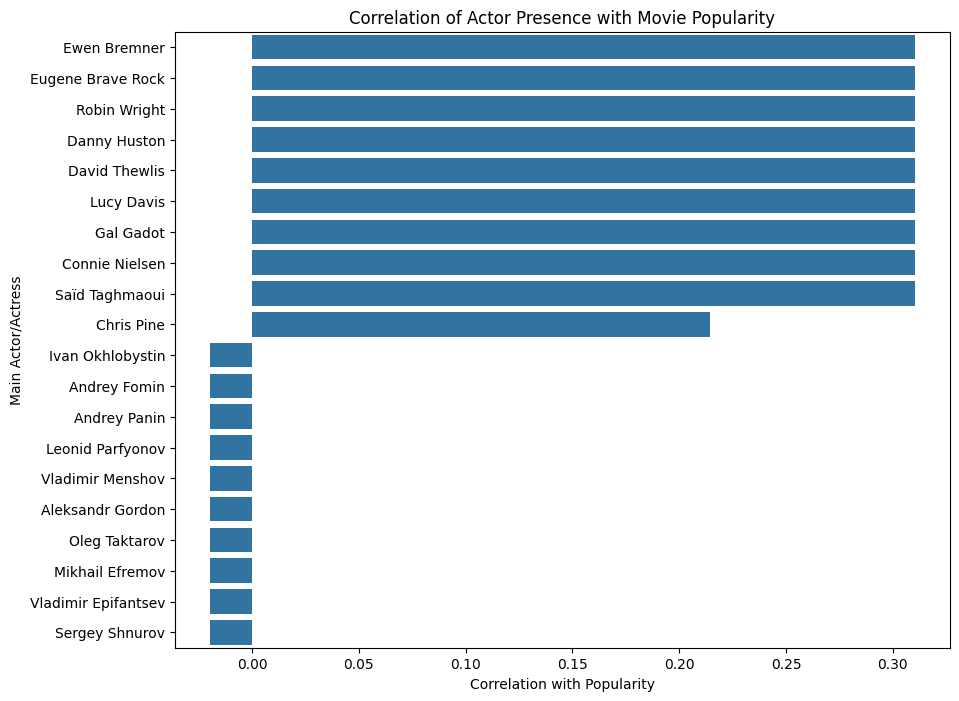

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the correlation matrixa Keep only the top 10 and bottom 10 correlations
top_10 = pop_matrix.head(10)
bottom_10 = pop_matrix.tail(10)
top_bottom_20 = pd.concat([top_10, bottom_10])

# Display the modified correlation series
# Plot the correlations

plt.figure(figsize=(10, 8))
sns.barplot(x=top_bottom_20.values, y=top_bottom_20.index)
plt.xlabel('Correlation with Popularity')
plt.ylabel('Main Actor/Actress')
plt.title('Correlation of Actor Presence with Movie Popularity')
plt.show()

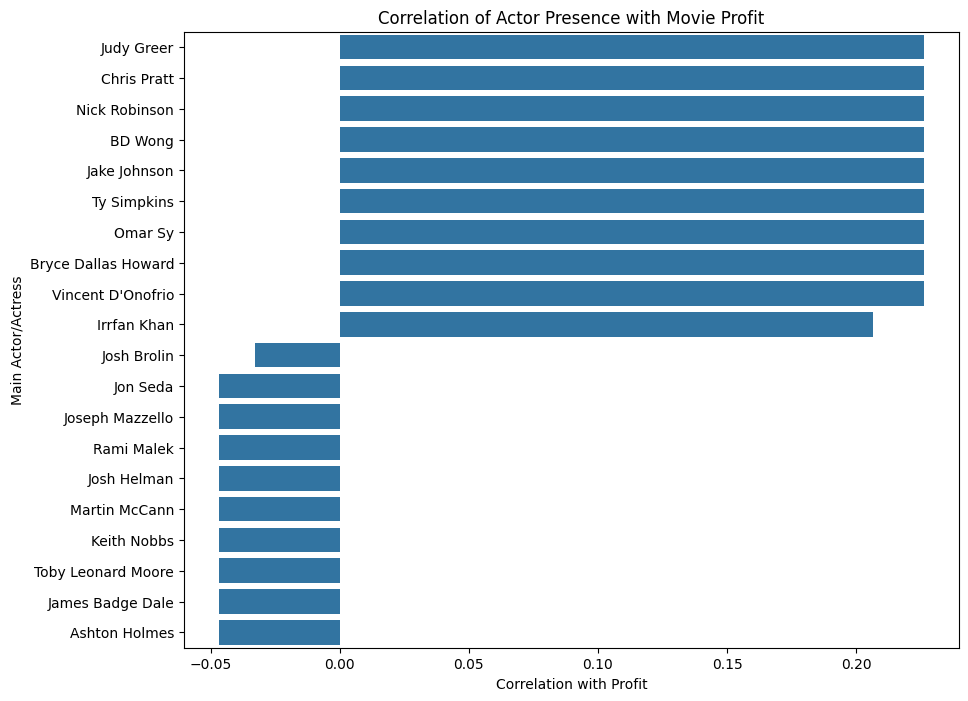

In [12]:

# Calculate the correlation  Keep only the top 10 and bottom 10 correlations
top_10 = profit_matrix.head(10)
bottom_10 = profit_matrix.tail(10)
top_bottom_20 = pd.concat([top_10, bottom_10])

# Display the modified correlation series
# Plot the correlations

plt.figure(figsize=(10, 8))
sns.barplot(x=top_bottom_20.values, y=top_bottom_20.index)
plt.xlabel('Correlation with Profit')
plt.ylabel('Main Actor/Actress')
plt.title('Correlation of Actor Presence with Movie Profit')
plt.show()

 # I found this odd. Anyone see something I am doing wrong? I will do a random forrest now to see which factor contributes the most to popularity and profit. That will also to rank them. I thought for sure this star-power would matter more than this, but perhaps when I compare it to the other variables which may influence popularity or profit, star-power may yet be at the top.
 # I realized after talking with Derrick that I can't form a correlation with a list of names even if I matrix them. So this isn't correlating what I think it is. It isn't doing anything meaningful. I feel dumb... moving on.


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# We assign a target for the random forest model:
target_column = 'profit'

# Create a new data frame suitable for the random forest model
# shallow copy: dataframe copy() method, to make sure we don't alter the original data
rand_forrest_df = cte_df.copy()

# try to drop columns which are not useful especially if they are strings
for col in rand_forrest_df.columns: #iterate through all columns
    if rand_forrest_df[col].dtype == 'object': # if the column is a string

        # then drop the column if it is not actor name genres or production companies
        if col not in ['actor_name', 'genres', 'ProductionCompanies']: 
            rand_forrest_df.drop(columns=[col], inplace=True)

print(' ---   This is what the column headers it looks like now:   \n')
print(rand_forrest_df.columns)
print('\n')
print(' ---   This is what it looks like now:\n')
print(rand_forrest_df.head())
print('\n')

 ---   This is what the column headers it looks like now:   

Index(['averageRating', 'actor_name', 'budget', 'profit', 'popularity',
       'genres', 'ProductionCompanies'],
      dtype='object')


 ---   This is what it looks like now:

   averageRating         actor_name     budget     profit  popularity  \
0            7.0         Chris Pine  149000000  671580447  294.337037   
1            7.0       Danny Huston  149000000  671580447  294.337037   
2            7.0      David Thewlis  149000000  671580447  294.337037   
3            7.0  Eugene Brave Rock  149000000  671580447  294.337037   
4            7.0       Ewen Bremner  149000000  671580447  294.337037   

                       genres  \
0  Action, Adventure, Fantasy   
1  Action, Adventure, Fantasy   
2  Action, Adventure, Fantasy   
3  Action, Adventure, Fantasy   
4  Action, Adventure, Fantasy   

                                 ProductionCompanies  
0  Dune Entertainment, Atlas Entertainment, Warne...  
1  Dune Enter

In [14]:

# Separate features and target (profit)

features = rand_forrest_df.drop(columns=[target_column])
features = features.drop(columns=['popularity'])
features = features.drop(columns=['budget']) #drop budget since this is presumably fixed
features = features.drop(columns=['averageRating']) #drop average rating since we can't control this 
target = rand_forrest_df[target_column]

# One-hot encode the categorical features (actor names, genres, production companies...)

for column in features.select_dtypes(include=['object']).columns:
    # Encode, append in place
    features = pd.concat([features, pd.get_dummies(features[column])], axis=1) 
    features.drop(column, axis=1, inplace=True) #drop the original column

print(' ---   This is the new size of our matrix (as in table):   \n')
print(features.size)
print('\n')
print(' ---   This is the columns:   \n')
print(' ---   \n see it is huge: ' + str(features.columns.size) + ' columns \n')
print(features.columns)
print('\n')
print(' ---   This is what the data looks like now:\n')
print(features.head())
print('\n')


 ---   This is the new size of our matrix (as in table):   

183600


 ---   This is the columns:   

 ---   
 see it is huge: 459 columns 

Index(['Aaron Eckhart', 'Aaron Heffernan', 'Abigail Spencer',
       'Adam David Thompson', 'Adam Langstaff', 'Adam Scott', 'Adil Hussain',
       'Aditi Rao Hydari', 'Alan Alda', 'Alan Tudyk',
       ...
       'Universal Pictures, Image Entertainment, Relativity Media, Rat Entertainment',
       'Universal Pictures, Marc Platt Productions',
       'Universal Pictures, Mike Zoss Productions, Working Title Films',
       'Universal Studios, Amblin Entertainment, Legendary Pictures, Fuji Television Network, Dentsu',
       'Vision Films, Writers Studio, The, Supernova LLC',
       'Walt Disney Pictures', 'Walt Disney Pictures, Jerry Bruckheimer Films',
       'Walt Disney Pictures, Pixar Animation Studios',
       'Walt Disney Pictures, Walt Disney Animation Studios', 'Warner Bros.'],
      dtype='object', length=459)


 ---   This is what the data

In [15]:

# Split into training and testing data
# Testing on 30% of the data
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Initialize the random forest model
# n_estimators is the number of trees in the forest
# random_state is the seed used by the random number generator
rand_for = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rand_for.fit(x_train, y_train)

# Predict the profit on the test seta
y_predict = rand_for.predict(x_test)

# Calculate the mean squared error
mse = np.mean((y_predict - y_test) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

# report the accuracy of the model
r2_score = rand_for.score(x_test, y_test)
print(f"R² (Model Accuracy): {r2_score}")


Mean Squared Error (MSE): 3278978454713300.5
R² (Model Accuracy): 0.9698187016405077


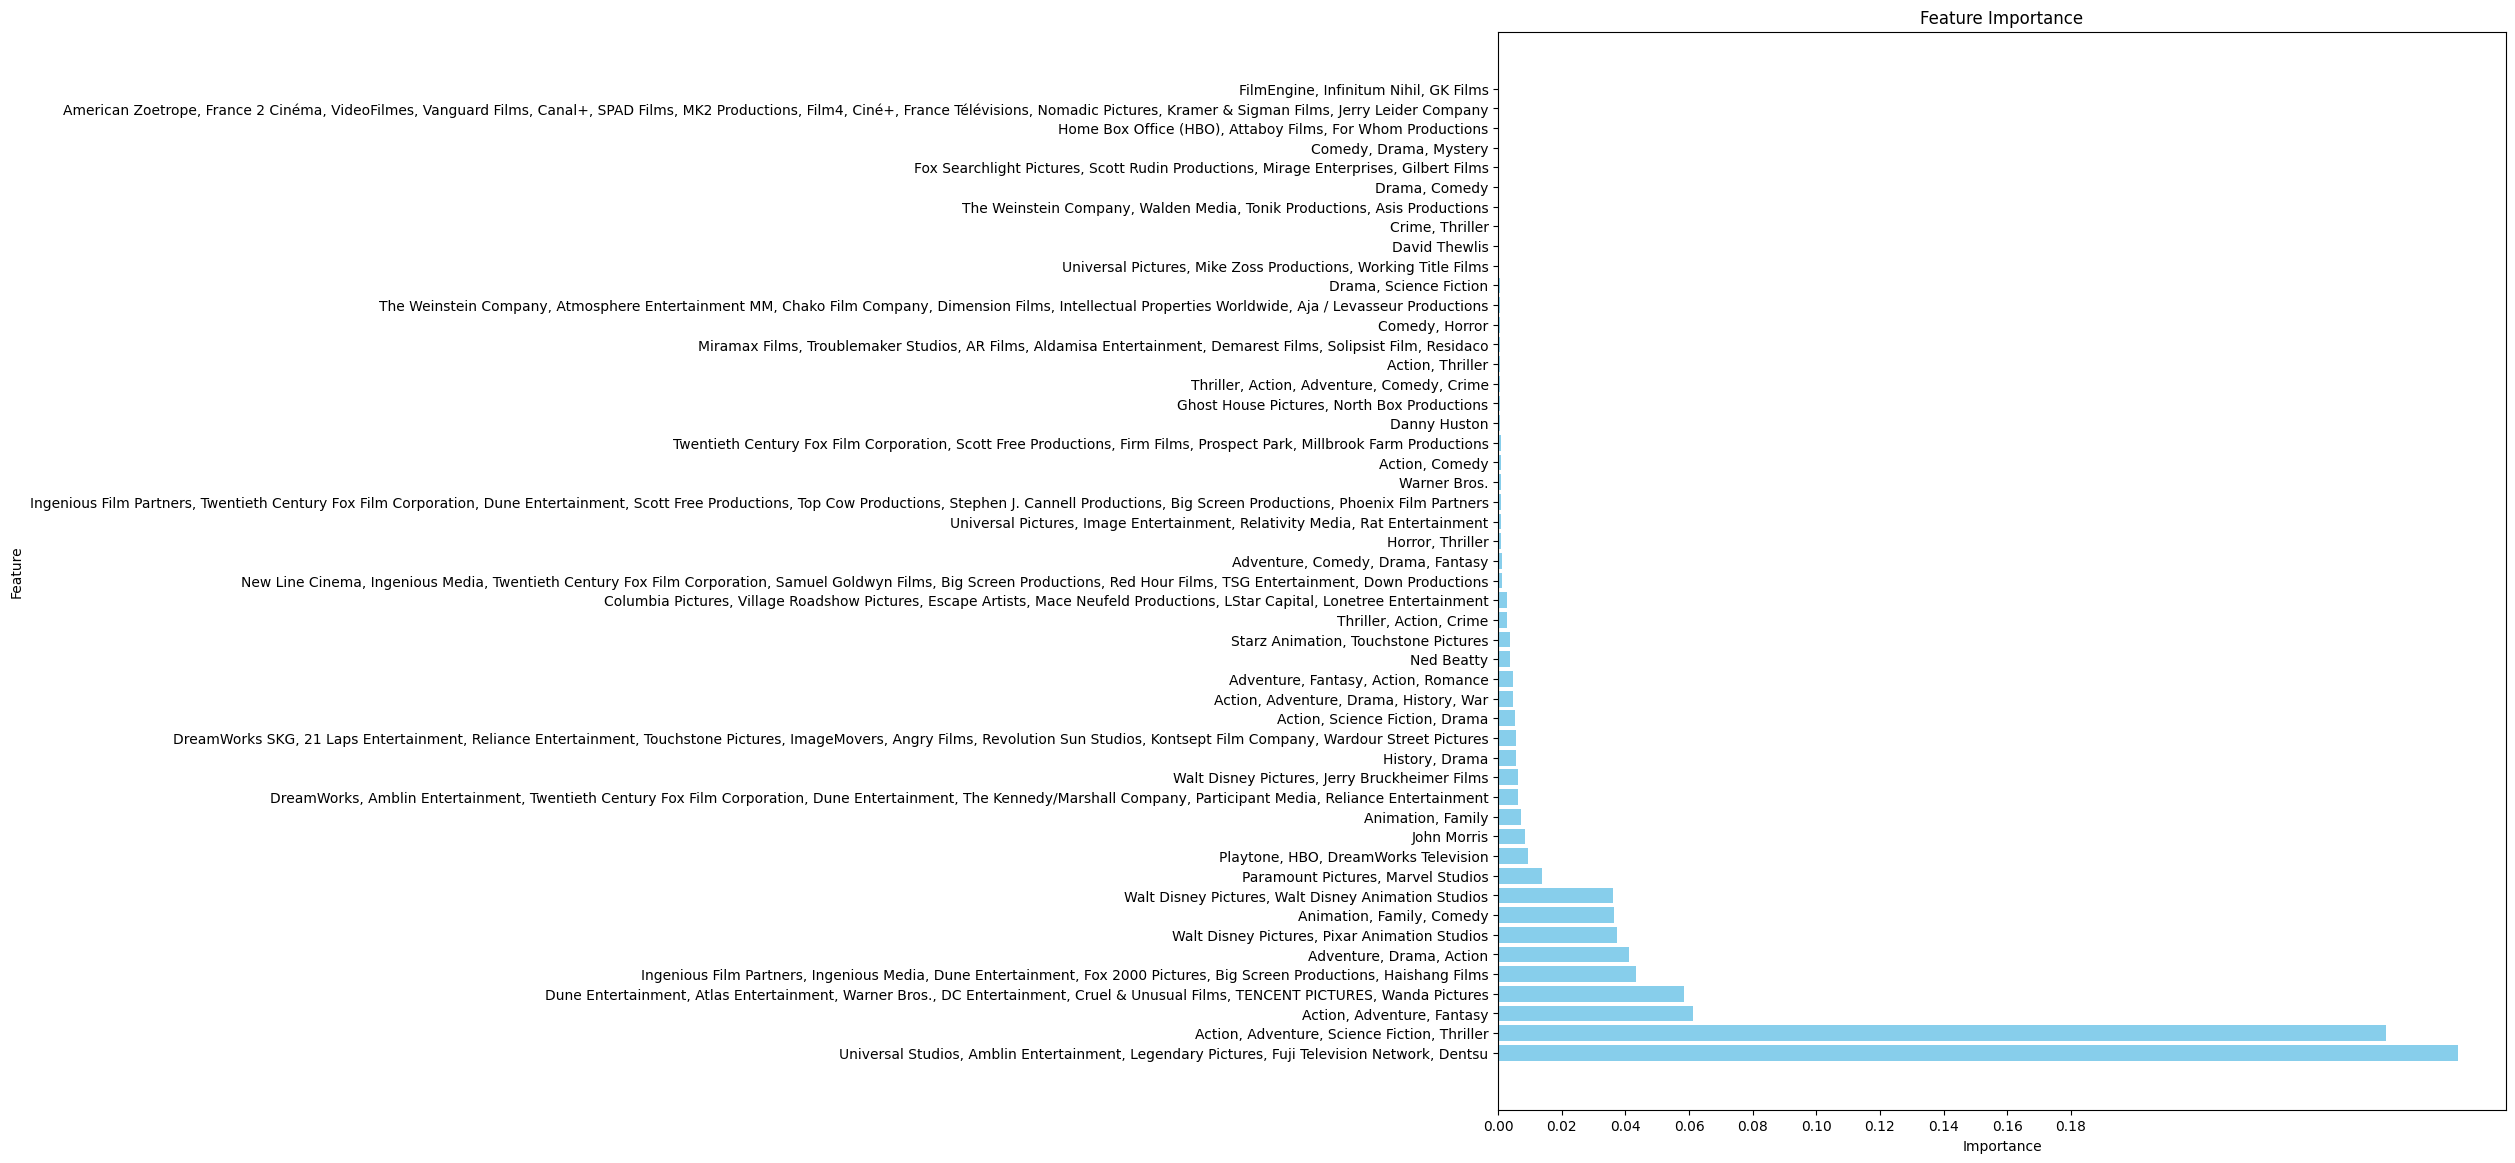

In [16]:
# Let's get a list of the most important features
# And get a visual representation of the importance of each feature
# There are way too many to display all of them, so we'll just display the top 10

import matplotlib.pyplot as plt
import numpy as np

# Get the feature importances, and the feature names
features_importance = rand_for.feature_importances_
feature_names = features.columns

# Create a dataframe with the feature importances
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': features_importance
})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

top_10_features = feature_df.head(50)

# plotting the feature importances
plt.figure(figsize=(13, 14))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
# Add labels
plt.title('Feature Importance')
plt.xticks(np.arange(0, 0.2, 0.02))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# The plot generated by the provided code is a horizontal bar plot that visualizes the importance of the top 10 features in your trained RandomForestRegressor model.  Feature importance is a measure of how much each feature contributes to the model's predictions. Higher importance values indicate that the feature has a greater impact on the model's output.


# Not suprisingly the budget and popularity and things that are clearly related to profit are most predictive. But since we cannot control those things we can draw a conclusion that the most predictive and controllable thing is the production company, namely a big budget one like Warner Bros, Hedya Films, whoever they are.



"""
 Let's try a different approach. 
 The problem is that we have tried to individualize the importance of the actors 
 This isn't going to work since there are so many different actors that any one actor's 
 importance is going to be very low. What we really need is a way to compute the importance that "ACTORS" catagories matter.
 New plan: We are going to try to predict the profit of a movie based on the actors in the movie as a whole.
 how? we are going to create a new column that is the sum of all the actors in the movie individually,
 then j
"""


Index(['averageRating', 'actor_name', 'budget', 'profit', 'popularity',
       'genres', 'ProductionCompanies'],
      dtype='object')
the features array contains 459 entries
actor importance is 0.0
actor importance is 1.4409091800930584e-20
actor importance is 1.56070381711688e-20
actor importance is 1.56070381711688e-20
actor importance is 2.8301527327206016e-20
actor importance is 2.8301527327206016e-20
actor importance is 4.447522645090136e-18
actor importance is 4.4542661103695515e-18
actor importance is 4.4542661103695515e-18
actor importance is 4.58202660239724e-18
actor importance is 4.619968938328209e-18
actor importance is 1.0649078966265463e-06
actor importance is 1.0649078966265463e-06
actor importance is 1.0649078966265463e-06
actor importance is 1.06490789662655e-06
actor importance is 1.0649078966265774e-06
actor importance is 1.0649078966280434e-06
actor importance is 1.0649078966280434e-06
actor importance is 1.0649078966280434e-06
actor importance is 1.064907896628044

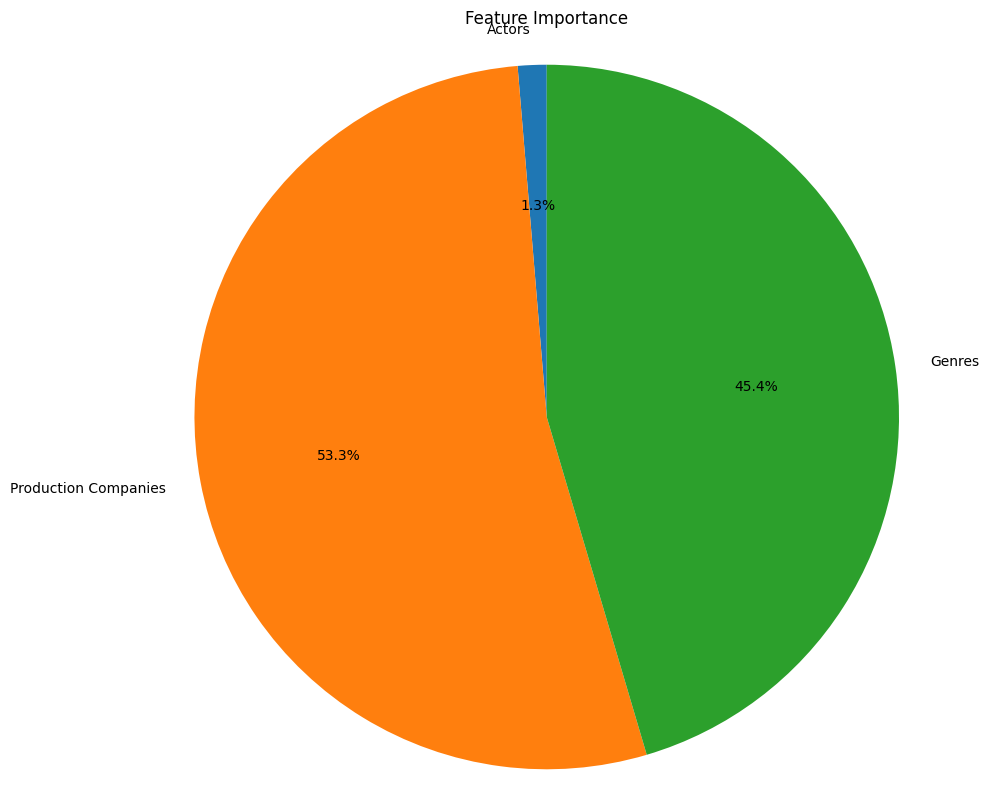

In [17]:
# Let's examine the importances of actors
# let's get the feature importances, and the feature names

#print(rand_forrest_df.columns)
f_importance = rand_for.feature_importances_
f_names = features.columns
importance_df = pd.DataFrame({'Feature' : f_names, 'Importances' : f_importance})
total_importance = 0
actor_importance = 0
production_importance = 0
genre_importance = 0

print(rand_forrest_df.columns)

print(f'the features array contains {f_names.size} entries')
for name in f_names:
    if name in rand_forrest_df['actor_name'].values:
        actor_importance += importance_df[importance_df['Feature'] == name]['Importances'].values[0]
        print(f"actor importance is {actor_importance}")
    if name in rand_forrest_df['ProductionCompanies'].values:
        production_importance += importance_df[importance_df['Feature'] == name]['Importances'].values[0]
    if name in rand_forrest_df['genres'].values:
        genre_importance += importance_df[importance_df['Feature'] == name]['Importances'].values[0]
    

print(f"Actor importance is {actor_importance}")
print(f"Production importance is {production_importance}")
print(f"Genre importance is {genre_importance}")
print(f"Total importance is {actor_importance + production_importance + genre_importance}")

# lets make a pie chart
plt.figure(figsize=(10, 10))
labels = ['Actors', 'Production Companies', 'Genres']
sizes = [actor_importance, production_importance, genre_importance]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Feature Importance') 
plt.show()